<a href="https://colab.research.google.com/github/JoeOlang/NLP/blob/main/Pytorch/Classifying_Names.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Classifying Names With a Character Level RNN (PyTorch)

In [1]:
%cd /content/drive/MyDrive/Colab Notebooks/NLP/Basics/RNN Name Classification

/content/drive/MyDrive/Colab Notebooks/NLP/Basics/RNN Name Classification


In [2]:
%ls

'Classifying Names.ipynb'   eng-fra.txt   names/


In [3]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

In [5]:
def findfiles(path): return glob.glob(path)

print(findfiles('names/*.txt'))

['names/French.txt', 'names/Dutch.txt', 'names/Italian.txt', 'names/Vietnamese.txt', 'names/Korean.txt', 'names/Portuguese.txt', 'names/German.txt', 'names/Chinese.txt', 'names/English.txt', 'names/Japanese.txt', 'names/Greek.txt', 'names/Polish.txt', 'names/Russian.txt', 'names/Irish.txt', 'names/Czech.txt', 'names/Scottish.txt', 'names/Arabic.txt', 'names/Spanish.txt']


In [12]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Unicode to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build a cateogry lines dict, a list of names per lang.
category_lines = {}
all_categories =[]

# read file and split into lines
def readlines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findfiles('names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readlines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)



Slusarski


In [13]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [16]:
import torch

# find letter index from all_letters >> ONE-HOT-ENC
def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor


def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(letterToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([1, 57])


In [18]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [19]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [26]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8355, -2.8521, -2.9204, -2.8689, -2.9517, -3.0252, -2.8649, -2.8294,
         -2.8673, -2.8910, -2.8454, -2.8438, -3.0373, -2.9247, -2.8410, -2.9046,
         -2.9252, -2.8307]], grad_fn=<LogSoftmaxBackward>)


In [28]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Chinese', 7)


In [33]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype = torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor


for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category = ', category, '/line =', line)

category =  Polish /line = Salomon
category =  English /line = Carmichael
category =  Irish /line = Clark
category =  Russian /line = Pohmelkin
category =  Czech /line = Kacirek
category =  Japanese /line = Enomoto
category =  Vietnamese /line = Thao
category =  Japanese /line = Hasekura
category =  Chinese /line = Rong
category =  Irish /line = John


In [34]:
criterion = nn.NLLLoss()

In [35]:
learning_rate = 0.005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)


    loss = criterion(output, category_tensor)
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha = -learning_rate)


    return output, loss.item()

In [39]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000


current_loss = 0
all_losses = []


def timeSince(since):
     now = time.time()
     s = now - since
     m = math.floor(s / 60)
     s -= m * 60
     return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 6s) 2.8728 Miller / German ✗ (Scottish)
10000 10% (0m 12s) 2.1384 O'Brien / English ✗ (Irish)
15000 15% (0m 17s) 2.8784 Ludkin / Russian ✗ (English)
20000 20% (0m 23s) 1.0706 Vinh / Vietnamese ✓
25000 25% (0m 28s) 1.6498 Wyrick / Polish ✓
30000 30% (0m 34s) 4.0890 Rendon / Scottish ✗ (Spanish)
35000 35% (0m 39s) 0.5545 Ferreira / Portuguese ✓
40000 40% (0m 45s) 2.8532 Rocha / Czech ✗ (Spanish)
45000 45% (0m 50s) 1.7483 Jirku / Polish ✗ (Czech)
50000 50% (0m 56s) 1.4845 Murphy / Irish ✓
55000 55% (1m 1s) 0.6111 Peng / Chinese ✓
60000 60% (1m 7s) 1.8845 Skala / Czech ✗ (Polish)
65000 65% (1m 12s) 0.7423 Daniau / French ✓
70000 70% (1m 18s) 0.3453 Silveira / Portuguese ✓
75000 75% (1m 24s) 1.9957 Chou / Korean ✗ (Chinese)
80000 80% (1m 29s) 3.9735 Saitoh / Arabic ✗ (Japanese)
85000 85% (1m 35s) 1.8581 Copeland / Irish ✗ (English)
90000 90% (1m 40s) 1.9205 Sha / Korean ✗ (Chinese)
95000 95% (1m 46s) 0.7113 Schwartz / German ✓
100000 100% (1m 51s) 0.8729 Saliba / Arabic ✓


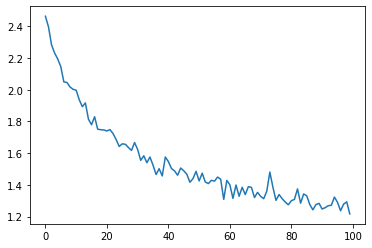

In [40]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

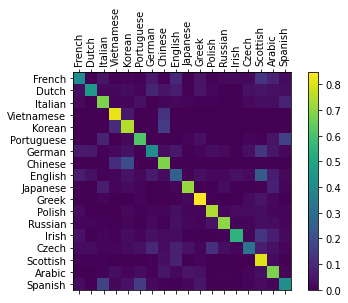

In [42]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000


def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation = 90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [45]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Emmanuel')


> Dovesky
(-0.54) Russian
(-1.18) Czech
(-2.76) English

> Jackson
(-0.17) Scottish
(-2.16) English
(-3.96) Russian

> Satoshi
(-1.14) Italian
(-1.38) Arabic
(-1.39) Japanese

> Emmanuel
(-1.31) German
(-1.98) English
(-2.15) Czech
